In [1]:
study_name = "lightgbm13"

In [2]:
import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import linregress



df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")
productos = pd.read_csv("../datasets/tb_productos.txt", sep="\t")
productos = productos.drop_duplicates(subset=["product_id"],keep="first")  # Eliminar duplicados por si acaso
stocks = pd.read_csv("../datasets/tb_stocks.txt", sep="\t")

productos_ok = pd.read_csv("https://storage.googleapis.com/open-courses/austral2025-af91/labo3v/product_id_apredecir201912.txt", sep="\t")
df = df[df["product_id"].isin(productos_ok["product_id"])]
df = df.groupby(by=["periodo","product_id"]).agg({
    "tn":"sum",
    "plan_precios_cuidados":"first",
    "customer_id":"nunique",
    }).reset_index()


productos_list = df['product_id'].unique()
periodos = df['periodo'].unique()
idx = pd.MultiIndex.from_product([productos_list, periodos], names=['product_id', 'periodo'])
completo = idx.to_frame(index=False)
# 4 filtrar combinaciones periodo_producto
completo = completo.merge(df, on=['periodo', 'product_id'], how='left')
nacimiento_producto = df.groupby('product_id')['periodo'].min().rename('nacimiento_producto')

completo = completo.merge(nacimiento_producto, on='product_id', how='left')
completo = completo[completo['periodo'] >= completo['nacimiento_producto']]



df = pd.merge(completo, productos, how="left", on="product_id")
df = df.merge(stocks, how="left", on=["product_id", "periodo"])

df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")

df["mes"] = df["periodo"].dt.month
df["year"] = df["periodo"].dt.year
df["quarter"] = df["periodo"].dt.quarter

# totales por cat1 por periodo
df["cat1_total"] = df.groupby(["periodo", "cat1"])["tn"].transform("sum")
df["cat1_mean"] = df.groupby(["periodo", "cat1"])["tn"].transform("mean")
df["cat1_mean_12"] = df.groupby(["periodo", "cat1"])["tn"].transform(lambda x: x.rolling(12).mean())
df["cat1_customers"] = df.groupby(["periodo", "cat1"])["customer_id"].transform("nunique")
# totales por cat2 por periodo
df["cat2_total"] = df.groupby(["periodo", "cat2"])["tn"].transform("sum")
df["cat2_mean"] = df.groupby(["periodo", "cat2"])["tn"].transform("mean")
df["cat2_mean_12"] = df.groupby(["periodo", "cat2"])["tn"].transform(lambda x: x.rolling(12).mean())
df["cat2_customers"] = df.groupby(["periodo", "cat2"])["customer_id"].transform("nunique")
# totales por cat3 por periodo
df["cat3_total"] = df.groupby(["periodo", "cat3"])["tn"].transform("sum")
df["cat3_mean"] = df.groupby(["periodo", "cat3"])["tn"].transform("mean")
df["cat3_mean_12"] = df.groupby(["periodo", "cat3"])["tn"].transform(lambda x: x.rolling(12).mean())
df["cat3_customers"] = df.groupby(["periodo", "cat3"])["customer_id"].transform("nunique")


# shift t-1 a t12
meses = ["tn"]
for i in range(1, 13):
    df[f"tn_t{i}"] = df.groupby("product_id")["tn"].shift(i)
    df[f"delta_t{i}"] = df[f"tn"] / df[f"tn_t{i}"]
    meses.append(f"tn_t{i}")
    df[f"cat1_t{i}"] = df.groupby("product_id")["cat1_total"].shift(i)
    df[f"cat2_t{i}"] = df.groupby("product_id")["cat2_total"].shift(i)
    df[f"cat3_t{i}"] = df.groupby("product_id")["cat3_total"].shift(i)
    df[f"customer_id_t{i}"] = df.groupby("product_id")["customer_id"].shift(i)
  
df["i_tn_t12"] = df["tn"] / df["tn_t12"]
df["i_tn_t6"] = df["tn"] / df["tn_t6"]
df["i_tn_t3"] = df["tn"] / df["tn_t3"]

df["i_tn_customers"] = df["tn"] / df["customer_id"]

df["promedio_t12"] = df[meses].mean(axis=1)
df["promedio_t6"] = df[meses[:6]].mean(axis=1)
df["promedio_t3"] = df[meses[:3]].mean(axis=1)

df["mediana_t12"] = df[meses].median(axis=1)
df["mediana_t6"] = df[meses[:6]].median(axis=1)
df["mediana_t3"] = df[meses[:3]].median(axis=1)

df["maximo_t12"] = df[meses].max(axis=1)
df["maximo_t6"] = df[meses[:6]].max(axis=1)
df["maximo_t3"] = df[meses[:3]].max(axis=1)

df["minimo_t12"] = df[meses].min(axis=1)
df["minimo_t6"] = df[meses[:6]].min(axis=1)
df["minimo_t3"] = df[meses[:3]].min(axis=1)

# Función para calcular la pendiente de una serie temporal
def calcular_pendiente(serie):
    datos = serie.dropna().values
    if len(datos) < 2:  # Mínimo 2 puntos para una regresión
        return np.nan
    x = np.arange(len(datos))  # [0, 1, 2, ..., n-1] (representa el tiempo)
    slope, _, _, _, _ = linregress(x, datos)
    return slope

# Aplicamos la función por grupo (producto) y reindexamos para alinear con df
df["pendiente_reg_12"] = (
    df.groupby("product_id")[meses]
    .apply(lambda grupo: grupo.apply(calcular_pendiente, axis=1))
    .reset_index(level=0, drop=True)  # Eliminamos el nivel de grupo para alinear índices
)

df['media_movil_3m'] = df.groupby('product_id')['tn'].transform(lambda x: x.rolling(3).mean())
df['media_movil_6m'] = df.groupby('product_id')['tn'].transform(lambda x: x.rolling(6).mean())
df['media_movil_12m'] = df.groupby('product_id')['tn'].transform(lambda x: x.rolling(12).mean())
df['diff_media_3_6'] = df['media_movil_3m'] - df['media_movil_6m']
df['diff_media_6_12'] = df['media_movil_6m'] - df['media_movil_12m']
df['diff_media_3_12'] = df['media_movil_3m'] - df['media_movil_12m']
df["diff_tn_mm3"] = df["tn"] - df['media_movil_3m']
df["diff_tn_mm6"] = df["tn"] - df['media_movil_6m']
df["diff_tn_mm12"] = df["tn"] - df['media_movil_12m']
df["i_tn_mm3"] = df["tn"] / df['media_movil_3m']
df["i_tn_mm6"] = df["tn"] / df['media_movil_6m']
df["i_tn_mm12"] = df["tn"] / df['media_movil_12m']

from scipy.stats import mode
def rolling_mode(x):
    return x.shift(1).rolling(6, min_periods=1).apply(lambda x: mode(x, keepdims=True)[0][0], raw=False)
#Moda o patrón de cantidad
df['modo_6m'] = df.groupby(['product_id'])['tn'].transform(rolling_mode)
df['modo_diff'] = df['tn'] - df['modo_6m']


# target t+2
df["target"] = df.groupby("product_id")["tn"].shift(-2)




cat_cols = ['cat1', 'cat2', 'cat3', 'brand']
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        
del completo, productos, stocks
gc.collect()
df

C:\Users\carre\AppData\Local\Temp\ipykernel_15164\4120308657.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["mediana_t12"] = df[meses].median(axis=1)
C:\Users\carre\AppData\Local\Temp\ipykernel_15164\4120308657.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["mediana_t6"] = df[meses[:6]].median(axis=1)
C:\Users\carre\AppData\Local\Temp\ipykernel_15164\4120308657.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

,product_id,periodo,tn,plan_precios_cuidados,customer_id,nacimiento_producto,cat1,cat2,cat3,brand,...,diff_media_3_12,diff_tn_mm3,diff_tn_mm6,diff_tn_mm12,i_tn_mm3,i_tn_mm6,i_tn_mm12,modo_6m,modo_diff,target
0,20001,2017-01-01,934.77222,0.0,186.0,201701,1,10,47,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1303.35771
1,20001,2017-02-01,798.01620,0.0,185.0,201701,1,10,47,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,934.77222,-136.75602,1069.96130
2,20001,2017-03-01,1303.35771,0.0,188.0,201701,1,10,47,0,...,NaN,291.309000,NaN,NaN,1.287841,NaN,NaN,798.01620,505.34151,1502.20132
3,20001,2017-04-01,1069.96130,0.0,104.0,201701,1,10,47,0,...,NaN,12.849563,NaN,NaN,1.012155,NaN,NaN,798.01620,271.94510,1520.06539
4,20001,2017-05-01,1502.20132,0.0,238.0,201701,1,10,47,0,...,NaN,210.361210,NaN,NaN,1.162838,NaN,NaN,798.01620,704.18512,1030.67391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22370,21087,2019-12-01,1.02205,0.0,51.0,201909,2,3,3,23,...,NaN,-0.087857,NaN,NaN,0.920843,NaN,NaN,0.29997,0.72208,NaN
22371,21214,2019-09-01,0.34250,0.0,2.0,201909,2,3,65,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.84012
22372,21214,2019-10-01,0.21735,0.0,38.0,201909,2,3,65,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34250,-0.12515,0.24428
22373,21214,2019-11-01,0.84012,0.0,43.0,201909,2,3,65,23,...,NaN,0.373463,NaN,NaN,1.800296,NaN,NaN,0.21735,0.62277,NaN


In [3]:
df_kgl = df[df["periodo"] == "2019-12-01"]
df_kgl["periodo"] = df_kgl["periodo"].astype(int)
df = df[~df["periodo"].isin(["2019-11-01", "2019-12-01"])]


C:\Users\carre\AppData\Local\Temp\ipykernel_15164\2505419454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kgl["periodo"] = df_kgl["periodo"].astype(int)
C:\Users\carre\AppData\Local\Temp\ipykernel_15164\2505419454.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df = df[~df["periodo"].isin(["2019-11-01", "2019-12-01"])]


In [4]:

# Separar features y target
X = df.drop(columns=["target"])
y = df["target"]
X_train = X[X["periodo"] < '2019-10-01']
X_train["periodo"] = X_train["periodo"].astype(int)
y_train = y[X["periodo"] < '2019-10-01']

X_val = X[X["periodo"] == '2019-10-01']
X_val["periodo"] = X_val["periodo"].astype(int)
y_val = y[X["periodo"] == '2019-10-01']



C:\Users\carre\AppData\Local\Temp\ipykernel_15164\4176657755.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["periodo"] = X_train["periodo"].astype(int)
C:\Users\carre\AppData\Local\Temp\ipykernel_15164\4176657755.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val["periodo"] = X_val["periodo"].astype(int)


In [5]:
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

def custom_mape_loss(y_true, y_pred):
    numerator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true))
    epsilon = np.finfo(float).eps  # Valor muy pequeño para evitar división por cero
    return numerator / (denominator + epsilon)

# === 2. Definición del objetivo para Optuna ===
def objective(trial):
    params = {
        "sample_weight": X_train["tn"].to_list(),
        "objective": "regression",
        "metric": ["rmse", "mape"],
        "boosting_type": "gbdt",
        "verbosity": -1,
        "n_jobs": -1,
        "seed": 42,
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 0.9),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 0.95),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 5),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 5.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 5.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 18),
        "max_bin": trial.suggest_int("max_bin", 2000, 8000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
        "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
        "path_smooth": trial.suggest_float("path_smooth", 0, 1),  # Nuevo parámetro útil
    }

    model = lgb.train(
        params,
        lgb.Dataset(X_train, label=y_train),
        valid_sets=[lgb.Dataset(X_val, label=y_val)],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )

    preds = model.predict(X_val)
    
    
    
    mape = custom_mape_loss(y_val, preds)
    # rmse = mean_squared_error(y_val, preds)
    # rmse = np.sqrt(rmse)
    
    #rmse = mean_squared_error(y_val, preds, squared=False)
    return mape

# === 3. Configurar almacenamiento SQLite para Optuna ===
os.makedirs("optuna_storage", exist_ok=True)
DB_PATH = "optuna_storage/optuna.db"
STUDY_NAME = study_name
storage_url = f"sqlite:///{DB_PATH}"

# === 4. Crear o cargar estudio ===
study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_url,
    direction="minimize",
    load_if_exists=True
)

# === 5. Ejecutar optimización ===
study.optimize(objective, n_trials=100)

# === 6. Mostrar resultados ===
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor MAE: {study.best_value:.4f}")

c:\Users\carre\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-12 11:19:46,332] A new study created in RDB with name: lightgbm13
[I 2025-07-12 11:20:00,120] Trial 0 finished with value: 0.336248470900602 and parameters: {'num_leaves': 86, 'learning_rate': 0.12128106167803426, 'feature_fraction': 0.8872267491425012, 'bagging_fraction': 0.8064259443769679, 'bagging_freq': 1, 'min_child_samples': 51, 'lambda_l1': 0.008796193798070406, 'lambda_l2': 0.05700401102925687, 'max_depth': 17, 'max_bin': 5505, 'min_data_in_leaf': 64, 'extra_trees': False, 'path_smooth': 0.7965708355480734}. Best is trial 0 with value: 0.336248470900602.
[I 2025-07-12 11:20:03,025] Trial 1 finished with value: 0.2617956429859395 and parameters: {'num_leaves': 115, 'learning_rate': 0.09492279802230057, 'feature_f

Mejores hiperparámetros encontrados:
{'num_leaves': 43, 'learning_rate': 0.19217389868539878, 'feature_fraction': 0.7735236296614333, 'bagging_fraction': 0.8431913575122814, 'bagging_freq': 1, 'min_child_samples': 53, 'lambda_l1': 0.8807339461350643, 'lambda_l2': 1.5514832066559785, 'max_depth': 4, 'max_bin': 5412, 'min_data_in_leaf': 126, 'extra_trees': False, 'path_smooth': 0.059645251548955676}
Mejor MAE: 0.2416


In [6]:
best_params = study.best_params.copy()
best_params.update({
    "objective": "regression",
    "metric": ["rmse", "mape"],
    "verbosity": -1,
    "n_jobs": -1,
    "seed": 42
})

model = lgb.train(
    best_params,
    lgb.Dataset(X_train, label=y_train),
    valid_sets=[lgb.Dataset(X_val, label=y_val)],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Asegurar las mismas columnas
X_kgl = df_kgl[X_train.columns]  # Misma estructura

# === 9. Hacer predicción sobre nuevos datos ===
preds_kgl = model.predict(X_kgl)


In [7]:
result = pd.DataFrame({"product_id": X_kgl["product_id"],  "tn": preds_kgl})

result = result[result["product_id"].isin(productos_ok["product_id"])]

result

,product_id,tn
35,20001,1349.023132
71,20002,1189.918994
107,20003,835.424952
143,20004,514.638743
179,20005,559.952926
...,...,...
22358,20962,2.804867
22362,20975,2.804867
22366,20995,2.804867
22370,21087,2.412143


In [8]:
result.to_csv(f"{study_name}.csv",sep=',', index=False)

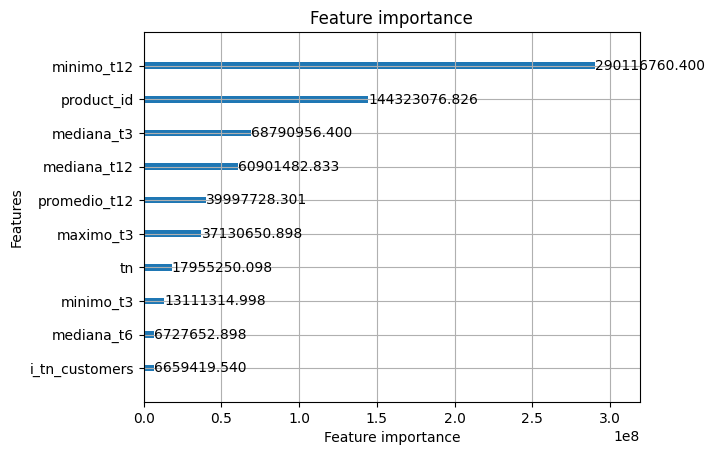

In [9]:
import matplotlib.pyplot as plt
from lightgbm import plot_importance  # Importación específica
# Visualizar importancia de características
plot_importance(model, importance_type='gain', max_num_features=10)  # Usar la función importada
plt.show()

In [13]:
import webbrowser
webbrowser.open("https://www.soundhelix.com/examples/mp3/SoundHelix-Song-3.mp3")

True